In [1]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [2]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[-2.]
[-1. -1. -8.]


In [3]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[ 0.33616233 -0.94180406 -0.12573998]
[0.19525401]
[ 0.29809746 -0.95453544 -0.80280492] -1.5094980917443563 False {}


In [4]:
# Learning episodes
epochs = 10000

Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


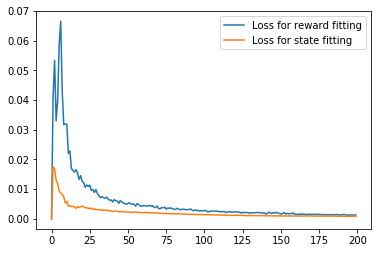

In [8]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()

print("Regression...")
for i in range(epochs):
    #observation = env.reset() # do we really need to call this every episode?
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    #observation = state
    if i%50==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [16]:
"""
    Discretization
    
    We translate the state from [-1, 1] [-1, 1] [-8, 8]
    to [0, 2] [0, 2] [0, 16]
    
    We translate the actions from [-2, 2] to [0, 4]
    
    Then we round the input with variable number of decimal places
    and multiply by 10 to the power of this number
    to make sure we get only positive integers
    
"""

def discretization(state_action, x, decimal_number):
    if state_action=="state":
        positive_s = [x[0]+1, x[1]+1, x[2]+8]
        rounded_s = np.around(positive_s, decimals=decimal_number)
        int_s = rounded_s * (10**decimal_number)
        int_s = np.array([int(int_s[0]), int(int_s[1]), int(int_s[2])])
        return int_s
    if state_action=="action":
        positive_a = x + 2
        rounded_a = np.around(positive_a, decimals=decimal_number)
        int_a = int(rounded_a * (10**decimal_number))
        return int_a
    else:
        print("Unknown discretization")
        return -1

In [17]:
"""
   Value Iteration
   
"""

'\n   Value Iteration\n   \n'

In [ ]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

In [20]:
"""
    Some stuff to see the predictions and discretization in action

"""
state = env.reset()

for _ in range(2):
    #env.render()
    print("Old state: ", discretization("state", state, 2))
    action = env.action_space.sample()
    print("Action: ", discretization("action", action, 2))
    state, reward, done, info = env.step(action)
    x = np.append(state,action)
    x = x.reshape(1,-1)
    print("Predicted reward: ", regressorReward.predict(x))
    print("Observed reward: ", reward)
    print("Predicted next state: ", discretization("state", regressorState.predict(x).T, 2))
    print("Observed next state: ", discretization("state", state, 2))
    print()

env.close()

Old state:  [  5 133 772]
Action:  239
Predicted reward:  [-7.91139799]
Observed reward:  -7.903636283607093
Predicted next state:  [  4 129 844]
Observed next state:  [  5 132 802]

Old state:  [  5 132 802]
Action:  269
Predicted reward:  [-8.02067978]
Observed reward:  -7.9037670751279325
Predicted next state:  [  3 126 874]
Observed next state:  [  5 131 836]

Old state:  [  5 131 836]
Action:  173
Predicted reward:  [-8.18136074]
Observed reward:  -8.022289535131966
Predicted next state:  [  4 126 874]
Observed next state:  [  4 128 856]

Old state:  [  4 128 856]
Action:  368
Predicted reward:  [-8.53087037]
Observed reward:  -8.202790828414068
Predicted next state:  [  2 118 928]
Observed next state:  [  3 123 902]

Old state:  [  3 123 902]
Action:  68
Predicted reward:  [-8.83865359]
Observed reward:  -8.570493112579983
Predicted next state:  [  1 113 886]
Observed next state:  [  2 118 900]

Old state:  [  2 118 900]
Action:  5
Predicted reward:  [-9.07241546]
Observed reward